In [12]:
import numpy as np
from numba import jit, prange, njit, vectorize
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate as itp
import itertools as it
import warnings as w
import os 
import pylab
import math
import time
#import scripts.tools as tools
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate as itp
from scipy.optimize import curve_fit
from scipy.signal import argrelmax
#import qcodes
#import scripts.tvregdiff as tvregdiff


# Capacitance Matrix calculations

This is a file for calculating the capacitance matrix of all the electrodes

## Set up

### Grid

In [15]:
R=0.75 #cm
RT = 0.75
H=0.2
N=500
M=200
position_of_electrons=100 

hr=R/N
hz=H/M

e=4.80324e-10
mass=9.1e-28

N_Vib=np.round(0.4/hr)
N_Vmb=np.round(0.57/hr)
N_Vob = np.round(0.7/hr)

N_Vit=N_Vib
N_Vmt=N_Vmb
N_Vot = N_Vob

x=np.linspace(0,R,N+1)

"""
folder = "../density_profile-main/GreenFunction/"
eps=1e-10
GreenFuncName = 'Green_njit_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(int(np.log10(eps))) + '.npy'
print(folder+GreenFuncName)
G = np.load(folder+GreenFuncName)

dGr = np.zeros((N, N))
dGzTOP = np.zeros((N, N))

for n in range(0, N):
    for i in range(0, N):
        # ----------- Green function difference along the charge pool ----------- #
        dGr[n,i] = -4 * np.pi * e * (G[position_of_electrons,i+1,n] - G[position_of_electrons,i,n])
        # ----------- Green function difference across the cell's top ------------# 
        dGzTOP[n, i] = -4 * np.pi * e * (G[M, i, n] - G[M-1, i, n])*(hr/hz)
"""

'\nfolder = "../density_profile-main/GreenFunction/"\neps=1e-10\nGreenFuncName = \'Green_njit_R\' + str(R).replace(\'.\',\'pt\') + \'_H\' + str(H).replace(\'.\',\'pt\') + \'_N\' + str(N) + \'_M\' + str(M) + \'_posiE\' + str(position_of_electrons) + \'_epsE\' + str(int(np.log10(eps))) + \'.npy\'\nprint(folder+GreenFuncName)\nG = np.load(folder+GreenFuncName)\n\ndGr = np.zeros((N, N))\ndGzTOP = np.zeros((N, N))\n\nfor n in range(0, N):\n    for i in range(0, N):\n        # ----------- Green function difference along the charge pool ----------- #\n        dGr[n,i] = -4 * np.pi * e * (G[position_of_electrons,i+1,n] - G[position_of_electrons,i,n])\n        # ----------- Green function difference across the cell\'s top ------------# \n        dGzTOP[n, i] = -4 * np.pi * e * (G[M, i, n] - G[M-1, i, n])*(hr/hz)\n'

In [121]:
A = np.zeros(N+1)
rdash = np.zeros(N+1)

A[0] = np.pi * np.power(hr/2, 2)
A[N] = np.pi * (N + 1 - 5/4) * np.power(hr, 2)
A[1:N] = 2 * np.pi * (np.arange(2, N+1) - 1) * np.power(hr, 2)

rdash[0:N+1] = (np.arange(0, N+1) + 1/2) * hr

## PhiTil Function

In [16]:
iRange = np.arange(2, N+1)
# function to efficiently copy a 2D array
@njit(parallel=True, fastmath=True)
def copyAr2D(dst, src):
    for i in prange(src.shape[0]):
        for j in range(src.shape[1]):
            dst[i, j] = src[i, j]


fitilStart = np.full((M+1,N+1),-1/300)
fitil = np.full((M+1,N+1),-1/300)
aStart = np.zeros((M-1, N+1))
a = np.zeros((M-1, N+1))

# function to calculate the potential created by the AC voltage
def fitilSOLUT(R,H,N,M,Vib,Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr):
    np.copyto(fitil, fitilStart)


    # --------------- boundary conditions on the electrodes ----------------- #
    fitil[0, 0:int(N_Vib)] = Vib
    fitil[0, int(N_Vib):int(N_Vmb)] = Vmb
    fitil[0, int(N_Vmb):int(N_Vob)] = Vob
    fitil[0, int(N_Vob):] = Vr
        
    fitil[M, 0:int(N_Vit)] = Vit
    fitil[M, int(N_Vit):int(N_Vmt)] = Vmt
    fitil[M, int(N_Vmt):int(N_Vot)] = Vot
    fitil[M, int(N_Vot):] = Vr
    
      
    
    fitil[:, N] = Vr
    
    
    # ---------------- relaxation for homogenious solution ------------------ #
    max_err= 1
    
    
    count = 0
    errHere = 1e-10
    print(count)
    np.copyto(a, aStart)
    while (max_err > errHere):

        count += 1
        if(count % 10000 == 0):
            print(max_err)

        np.copyto(a, fitil[1:M, 0:N+1])
        fitil[1:M, 0] = (4 * (hz/hr) * fitil[1:M, 1] + (hr/hz) * fitil[0:M-1, 0] + (hr/hz) * fitil[2:M+1, 0])/(4 * hz/hr + 2 * hr/hz)

        fitil[1:M, 1:N] = ((iRange - 1/2 - 1) * (hz/hr) * fitil[1:M, 0:N-1] + (iRange + 1/2 - 1) * (hz/hr) * fitil[1:M, 2:N+1] + (iRange-1) * (hr/hz) * fitil[0:M-1, 1:N] + (iRange-1) * (hr/hz) * fitil[2:M+1, 1:N])/(2 * (iRange-1) * (hz/hr + hr/hz))
       
        max_err = np.amax(np.abs(fitil[1:M, 0:N+1] - a))

    return fitil
    

### Loop for each electrode

In [82]:
# only 1 V is applied to one electrode
# all the other electrodes are set to 0 (they only participate in the DC potential)


Vr=0
V_electrodes = [1, 0, 0, 0, 0, 0]
phitil_electrodes = []
for i in range(6):
    Vib_AC, Vmb_AC, Vob_AC, Vit_AC, Vmt_AC, Vot_AC = np.asarray(V_electrodes)/300
    V_electrodes = [V_electrodes[-1]] + V_electrodes[:-1]
    print(Vib_AC, Vmb_AC, Vob_AC, Vit_AC, Vmt_AC, Vot_AC)
# calculate the potential created by the AC voltage
    phitil = fitilSOLUT(R,H,N,M,Vib_AC,Vmb_AC,Vob_AC,N_Vib,N_Vmb,Vit_AC,Vmt_AC,Vot_AC,N_Vit,N_Vmt,N_Vot, N_Vob,Vr)
    #plt.pcolormesh(phitil)
    #plt.show()
    phitil_electrodes.append(np.copy(phitil))
    print(phitil_electrodes[0])
    




0.0033333333333333335 0.0 0.0 0.0 0.0 0.0
0
2.3196415137555042e-07
9.84230138105285e-08
4.1640159469807925e-08
1.752132549812102e-08
7.349699744640947e-09
3.0786157670468356e-09
1.2884192449914844e-09
5.386847313701426e-10
2.249447952126088e-10
[[3.33333333e-03 3.33333333e-03 3.33333333e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.31644073e-03 3.31644071e-03 3.31644062e-03 ... 4.26967892e-09
  2.13207632e-09 0.00000000e+00]
 [3.29954819e-03 3.29954813e-03 3.29954796e-03 ... 8.53827656e-09
  4.26361270e-09 0.00000000e+00]
 ...
 [3.28836681e-05 3.28836128e-05 3.28834417e-05 ... 8.39049260e-09
  4.18987663e-09 0.00000000e+00]
 [1.64418065e-05 1.64417788e-05 1.64416933e-05 ... 4.19575046e-09
  2.09519008e-09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
0.0 0.0033333333333333335 0.0 0.0 0.0 0.0
0
2.096518326945209e-07
8.473541816204477e-08
3.434655287200446e-08
1.406916310634377e-08
5.819668345700187e-09
2

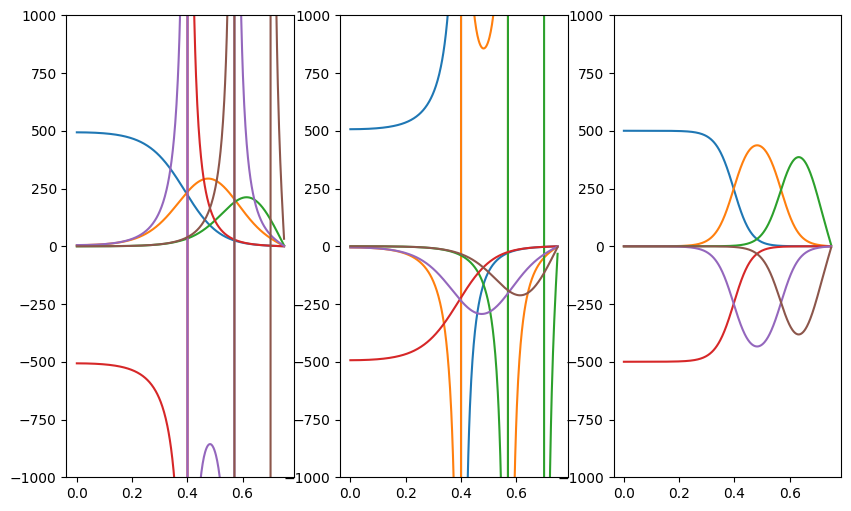

In [ ]:
#EztilTOP = np.zeros(N)
#EztilBOT = np.zeros(N)
#Eztil_e = np.zeros(N)
radius = np.linspace(0,R,N+1)
fig, ax = plt.subplots(1,3, figsize=(10, 6))
for phitil in phitil_electrodes:
    EztilTOP = np.zeros(N)
    EztilBOT = np.zeros(N)
    Eztil_e = np.zeros(N)
    for i in range(0, N):
        EztilTOP[i] = (phitil[M-1,i]-phitil[M,i])/hz
        EztilBOT[i] = (phitil[0,i]-phitil[1,i])/hz
        Eztil_e[i] = (phitil[position_of_electrons-1,i]-phitil[position_of_electrons,i])/hz
    #EztilTOP = np.gradient(phitil, hz, axis=0)[M]
    #EztilBOT = np.gradient(phitil, hz, axis=0)[0]
    #Eztil_e = np.gradient(phitil, hz, axis=0)[position_of_electrons]
    

    ax[0].plot(300*EztilTOP/1e-2, label="TOP")
    ax[1].plot(radius,300*EztilBOT/1e-2, label="BOT")
    ax[2].plot(radius, 300*Eztil_e/1e-2, label="electrons")
    #plt.xlim(0, 300)

for axes in ax:
    axes.set_ylim(-1000, 1000)
plt.show()






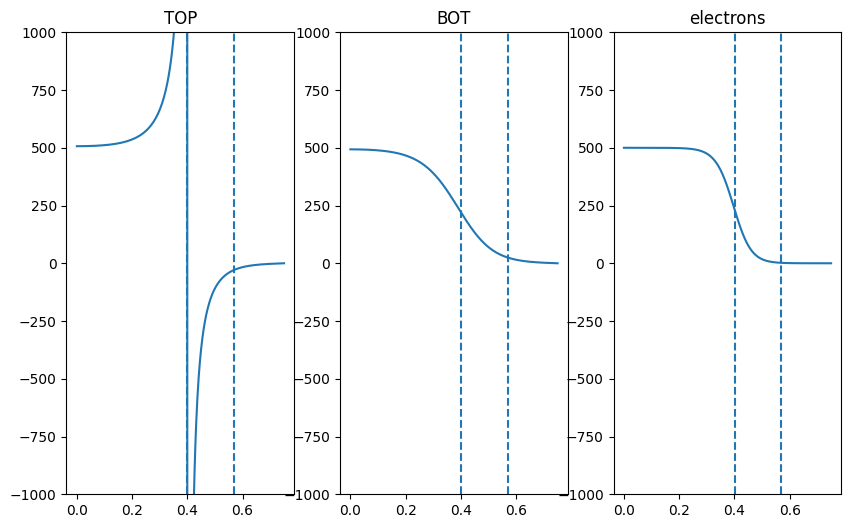

In [192]:
phitil_it = phitil_electrodes[3]

radius = np.linspace(0,R,N+1)
fig, ax = plt.subplots(1,3, figsize=(10, 6))

EztilTOP = np.gradient(phitil_it, hz, axis=0)[M-1]
EztilBOT = np.gradient(phitil_it, hz, axis=0)[0]
Eztil_e = np.gradient(phitil_it, hz, axis=0)[position_of_electrons]


ax[0].set_title("TOP")
ax[0].plot(radius, 300*EztilTOP/1e-2, label="TOP")
ax[1].set_title("BOT")
ax[1].plot(radius, 300*EztilBOT/1e-2, label="BOT")
ax[2].set_title("electrons")
ax[2].plot(radius, 300*Eztil_e/1e-2, label="electrons")
    #plt.xlim(0, 300)

for axes in ax:
    axes.set_ylim(-1000, 1000)
    axes.vlines(N_Vib*hr, -1000, 1000, linestyles="dashed")
    axes.vlines(N_Vmb*hr, -1000, 1000, linestyles="dashed")
plt.show()

In [164]:
from scipy.integrate import simpson
#Q_bi = 1/4/np.pi*simpson(EztilBOT[0:int(N_Vib)]*, dx = radius[0:int(N_Vib)])
#print(Q_bi)
Q_bi = 1/(4*np.pi)*np.sum(EztilBOT[0:int(N_Vib)]*A[0:int(N_Vib)])
C_bi = Q_bi/(1/300)
stat_farad_to_farad = 1.1127E-12
C_bi = C_bi*stat_farad_to_farad
C_bi

np.float64(1.7361351758529273e-13)

In [ ]:
C_bi = 8.854e-12*np.abs(np.sum(300/1e-2*EztilBOT[0:int(N_Vib)]*(A*1e-4)[0:int(N_Vib)]))

C_bm =  8.854e-12*np.abs(np.sum(300/1e-2*EztilBOT[int(N_Vib):int(N_Vmb)]*(A*1e-4)[int(N_Vib):int(N_Vmb)]))

C_bo =  8.854e-12*np.abs(np.sum(300/1e-2*EztilBOT[int(N_Vmb):int(N_Vob)]*(A*1e-4)[int(N_Vmb):int(N_Vob)]))

C_tm =  8.854e-12*np.abs(np.sum(300/1e-2*EztilTOP[int(N_Vib):int(N_Vmb)]*(A*1e-4)[int(N_Vib):int(N_Vmb)]))

C_to =  8.854e-12*np.abs(np.sum(300/1e-2*EztilTOP[int(N_Vmb):int(N_Vob)]*(A*1e-4)[int(N_Vmb):int(N_Vob)]))

self(C_bi, C_bm, C_bo, C_tm, C_to)
total_c = C_bi + C_bm + C_bo + C_tm + C_to

1.7360204230368314e-13 4.273652487722768e-14 4.543277248757013e-15 3.024504922640029e-13 4.9427760567892345e-15


In [204]:
self_C_ti = 8.854e-12*np.abs(np.sum(300/1e-2*EztilTOP[0:int(N_Vib)]*(A*1e-4)[0:int(N_Vib)]))
self_C_ti

np.float64(5.310134543033373e-13)

In [205]:
print(total_c)

5.2827511275046e-13


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,